In [146]:
#Data Analysis and Wrangling
import pandas as pd 
import numpy as np

#Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Splitting
from sklearn.model_selection import train_test_split

# encoders
import category_encoders
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#metrics
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve,roc_auc_score
from sklearn.metrics import mean_squared_error

#Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#pipeline
from sklearn.pipeline import make_pipeline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

# Boosted Models
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier 

# Permutation Importance
from sklearn.inspection import permutation_importance 
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

In [147]:
path = 'C:/Users/ndand/Desktop/District Data Stuff/archive/College_Data.csv'
df = pd.read_csv(path)

In [148]:
def wrangle(df):
    
    #fix column names 
    Cnames = ['College','Private?','Applications','Accepted','Enrolled','Top10HS','Top25HS','FullTime',
             'PartTime','OutStateTuition','RoomBoardCost','BooksCost','PersonalSpend','PhD','TeachTermDegree',
             'S/F.Ratio','AlumDon','Exp/Student','GradRate']
    
    Old =df.columns
    Combine = dict(zip(Old,Cnames))
    df = df.rename(columns = Combine)
    
    #OverAll cost per College
    df['OverAllCost'] = df['OutStateTuition'] + df['RoomBoardCost'] + df['BooksCost'] + df['PersonalSpend']

    
    #Acceptance Rate
    df['AcceptRate'] = round(df["Accepted"] / df["Applications"], 2)
    
    
    #Drop high cardinality columns
    cutoff = 500
    drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)
    
    #Binary Private col
    df['Private?'] = df['Private?'].apply(lambda x : 1 if x == 'Yes' else 0)
    
    return df
df = wrangle(df)

In [149]:
df.head()

,Private?,Applications,Accepted,Enrolled,Top10HS,Top25HS,FullTime,PartTime,OutStateTuition,RoomBoardCost,BooksCost,PersonalSpend,PhD,TeachTermDegree,S/F.Ratio,AlumDon,Exp/Student,GradRate,OverAllCost,AcceptRate
0,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,13390,0.74
1,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,20980,0.88
2,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,16565,0.77
3,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,19735,0.84
4,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,13980,0.76


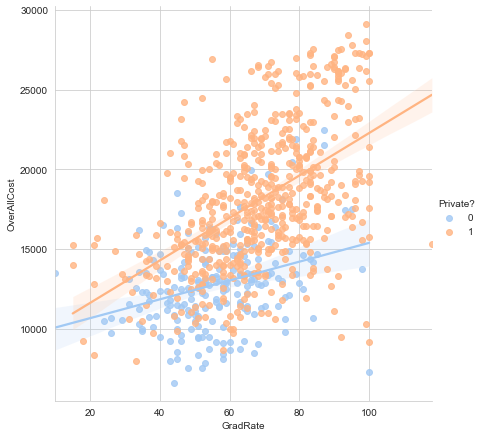

In [150]:
sns.set_style('whitegrid')
sns.lmplot('GradRate','OverAllCost',df,hue='Private?',palette='pastel',size=6,aspect=1)

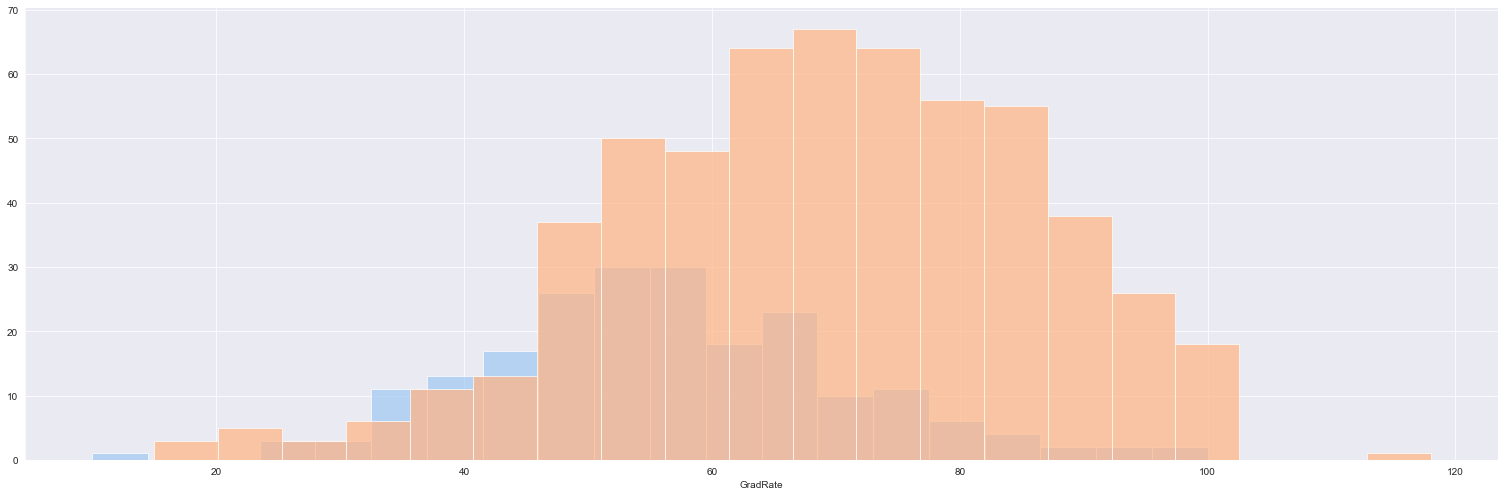

In [151]:
sns.set_style('darkgrid')
g = sns.FacetGrid(df,hue="Private?",palette='pastel',size=7,aspect=3)
g = g.map(plt.hist,'GradRate',bins=20,alpha=0.7)

In [152]:
df[df['GradRate']>100]

,Private?,Applications,Accepted,Enrolled,Top10HS,Top25HS,FullTime,PartTime,OutStateTuition,RoomBoardCost,BooksCost,PersonalSpend,PhD,TeachTermDegree,S/F.Ratio,AlumDon,Exp/Student,GradRate,OverAllCost,AcceptRate
95,1,3847,3433,527,9,35,1010,12,9384,4840,600,500,22,47,14.3,20,7697,118,15324,0.89


In [131]:
update_df = df.drop([df.index[95]],inplace = True)
update_df

In [132]:
df[df['GradRate']>100]

,Private?,Applications,Accepted,Enrolled,Top10HS,Top25HS,FullTime,PartTime,OutStateTuition,RoomBoardCost,BooksCost,PersonalSpend,PhD,TeachTermDegree,S/F.Ratio,AlumDon,Exp/Student,GradRate,OverAllCost,AcceptRate


In [133]:
# Feat function : print the important features to a model
# Input : features and model
# Output : none 
def Feat(Chara, model):
    
    Attributes = Chara.columns
    Attributes = list(zip(Chara, model.feature_importances_))
    Sort = sorted(Attributes,key = lambda x : x[1], reverse = True)
    
    print('Important Factors:')
    i = 0
    
    for label, coef in Sort:
        if i < 5:
            print(label)
        i += 1    

In [134]:
# Classifier Function : split, train, test
# Input : df
# Output : none

def Classifier(df):
    
    #Split 
    Target = 'Private?'
    y = df[Target]
    X = df.drop(Target, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)
    
    #Baseline 
    baseline_acc = y_train.value_counts(normalize=True).max()
    print('Baseline accuracy:', baseline_acc)
    
    #Train
    model = RandomForestClassifier(max_depth = 10, n_estimators = 75, random_state = 42, n_jobs = -1)
    model.fit(X_train,y_train);
    
    #predict
    predict = model.predict(X_test)
    
    #Test
    print('RandomForestClassifier Score:', model.score(X_test,y_test))
    print("Root MSE: ", np.sqrt(mean_squared_error(y_test, predict)))
    
    #Feature Importance
    Feat(X, model)

In [135]:
for x in range(0,5):
    Classifier(df)

Baseline accuracy: 0.7209677419354839
RandomForestClassifier Score: 0.9487179487179487
Root MSE:  0.22645540682891915
Important Factors:
FullTime
OutStateTuition
Enrolled
OverAllCost
PartTime
Baseline accuracy: 0.7387096774193549
RandomForestClassifier Score: 0.9743589743589743
Root MSE:  0.16012815380508713
Important Factors:
OutStateTuition
FullTime
Enrolled
OverAllCost
PartTime
Baseline accuracy: 0.7387096774193549
RandomForestClassifier Score: 0.9230769230769231
Root MSE:  0.2773500981126146
Important Factors:
FullTime
OutStateTuition
Enrolled
OverAllCost
PartTime
Baseline accuracy: 0.7080645161290322
RandomForestClassifier Score: 0.967948717948718
Root MSE:  0.17902871850985821
Important Factors:
FullTime
OutStateTuition
Enrolled
OverAllCost
PartTime
Baseline accuracy: 0.7274193548387097
RandomForestClassifier Score: 0.967948717948718
Root MSE:  0.17902871850985821
Important Factors:
FullTime
OutStateTuition
Enrolled
OverAllCost
S/F.Ratio


In [136]:
def Regression(df):
    
    #Split 
    Target = 'AcceptRate'
    y = df[Target]
    X = df.drop(Target, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)
    
    #Baseline 
    baseline_acc = y_train.value_counts(normalize=True).max()
    print('Baseline accuracy:', baseline_acc)
    
    #Train
    model = RandomForestRegressor(n_estimators = 100)
    model.fit(X_train,y_train);
    
    #predict
    predict = model.predict(X_test)
    
    #Test
    print('RandomForestRegressor Score:', model.score(X_test,y_test))
    print("Root MSE: ", np.sqrt(mean_squared_error(y_test, predict)))
    
    #Feature Importance
    Feat(X, model)

In [137]:
col = df.drop(['Enrolled','Accepted',], axis = 1)
col.head()

,Private?,Applications,Top10HS,Top25HS,FullTime,PartTime,OutStateTuition,RoomBoardCost,BooksCost,PersonalSpend,PhD,TeachTermDegree,S/F.Ratio,AlumDon,Exp/Student,GradRate,OverAllCost,AcceptRate
0,1,1660,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,13390,0.74
1,1,2186,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,20980,0.88
2,1,1428,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,16565,0.77
3,1,417,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,19735,0.84
4,1,193,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,13980,0.76


In [139]:
for x in range(0,5):
    Regression(col)

Baseline accuracy: 0.04838709677419355
RandomForestRegressor Score: 0.4252548828046254
Root MSE:  0.11657454036597552
Important Factors:
Top10HS
Applications
Top25HS
FullTime
OutStateTuition
Baseline accuracy: 0.0532258064516129
RandomForestRegressor Score: 0.3697526361815566
Root MSE:  0.11008290465569981
Important Factors:
Top10HS
Applications
Top25HS
OutStateTuition
FullTime
Baseline accuracy: 0.0467741935483871
RandomForestRegressor Score: 0.5448003818650762
Root MSE:  0.10250741217727646
Important Factors:
Top10HS
Applications
Top25HS
FullTime
OutStateTuition
Baseline accuracy: 0.04516129032258064
RandomForestRegressor Score: 0.49829780945664703
Root MSE:  0.10185774236398126
Important Factors:
Top10HS
Top25HS
Applications
FullTime
GradRate
Baseline accuracy: 0.05
RandomForestRegressor Score: 0.4367084856629757
Root MSE:  0.1005999528470094
Important Factors:
Top10HS
Applications
Top25HS
GradRate
FullTime
